# Data Mining Work 1

## 1. Author Info
* sid: 5140369016
* name: 邢俊劼
* email: gavinxing9016@gmail.com

## 2. Data Set

* HTRU2 Data Set
* <http://archive.ics.uci.edu/ml/datasets/HTRU2>

## 2.1 Information
> HTRU2 is a data set which describes a sample of pulsar candidates collected during the High Time Resolution Universe Survey (South) . 

> Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as probes of space-time, the inter-stellar medium, and states of matter .

> As pulsars rotate, their emission beam sweeps across the sky, and when this crosses our line of sight, produces a detectable pattern of broadband radio emission. As pulsars 
rotate rapidly, this pattern repeats periodically. Thus pulsar search involves looking for periodic radio signals with large radio telescopes. 

> Each pulsar produces a slightly different emission pattern, which varies slightly with each rotation . Thus a potential signal detection known as a 'candidate', is averaged over many rotations of the pulsar, as determined by the length of an observation. In the absence of additional info, each candidate could potentially describe a real pulsar. However in practice almost all detections are caused by radio frequency interference (RFI) and noise, making legitimate signals hard to find. 

> Machine learning tools are now being used to automatically label pulsar candidates to facilitate rapid analysis. Classification systems in particular are being widely adopted, 
which treat the candidate data sets as binary classification problems. Here the legitimate pulsar examples are a minority positive class, and spurious examples the majority negative class. At present multi-class labels are unavailable, given the costs associated with data annotation. 

> The data set shared here contains 16,259 spurious examples caused by RFI/noise, and 1,639 real pulsar examples. These examples have all been checked by human annotators. 

> The data is presented in two formats: CSV and ARFF (used by the WEKA data mining tool). Candidates are stored in both files in separate rows. Each row lists the variables first, and the class label is the final entry. The class labels used are 0 (negative) and 1 (positive). 

> Please note that the data contains no positional information or other astronomical details. It is simply feature data extracted from candidate files using the PulsarFeatureLab tool .

## 2.2 Attribute Info
> Each candidate is described by 8 continuous variables, and a single class variable. The first four are simple statistics obtained from the integrated pulse profile (folded profile). This is an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged in both time and frequency . The remaining four variables are similarly obtained from the DM-SNR curve. These are summarised below: 

> 1. Mean of the integrated profile. 
> 2. Standard deviation of the integrated profile. 
> 3. Excess kurtosis of the integrated profile. 
> 4. Skewness of the integrated profile. 
> 5. Mean of the DM-SNR curve. 
> 6. Standard deviation of the DM-SNR curve. 
> 7. Excess kurtosis of the DM-SNR curve. 
> 8. Skewness of the DM-SNR curve. 
> 9. Class 

> 17,898 total examples. 
> 1,639 positive examples. 
> 16,259 negative examples.



## 3. Load data

In [1]:
import pandas as pd
import numpy as np
from time import time
import os

In [2]:
data_path = './data/HTRU_2.csv'
data = pd.read_csv(data_path, header=None) # no head in .csv
data.columns = ["M1", "SD1", "EK1", "S1", "M2", "SD2", "EK2", "S2", "Y"]
data.head()

,M1,SD1,EK1,S1,M2,SD2,EK2,S2,Y
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [3]:
cols = list(data.columns) # split data to X and Y
X = data[cols[0:8]] 
Y = data['Y']

## 4. Data Explore

### 4.1 Data Correlation
> 在概率论和统计学中，相关（Correlation，或称相关系数或关联系数），显示两个随机变量之间线性关系的强度和方向。在统计学中，相关的意义是用来衡量两个变量相对于其相互独立的距离。在这个广义的定义下，有许多根据数据特点而定义的用来衡量数据相关的系数。<https://zh.wikipedia.org/wiki/%E7%9B%B8%E5%85%B3>

In [4]:
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 240 , 15 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

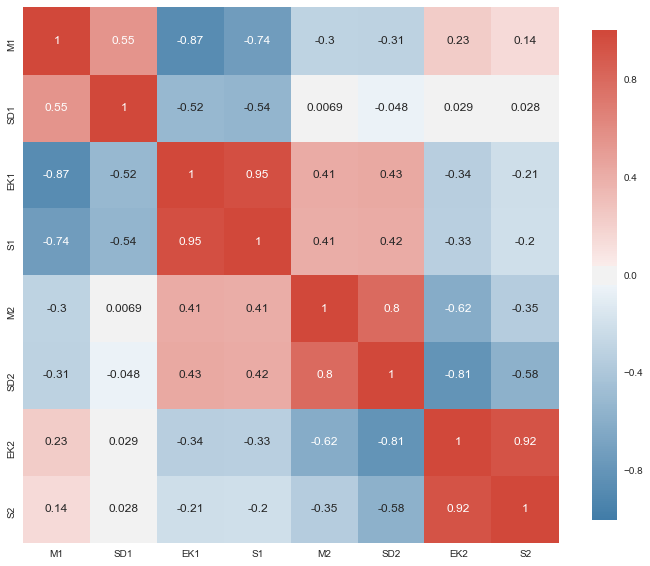

In [5]:
plot_correlation_map(X)

### 从上图中我们可以发现，对应的M和SD属性，对应的EK和S属性之间相关性非常大，在选择的分类算法复杂性与属性个数成非线性相关时，我们可以考虑将M和SD取其一，EK和S取其一，这样可以将属性个数从8降低到4，从而节省模型拟合时间。
### 但由于我所实现的是KNN分类算法，这是一种与属性呈线性相关的算法，因此我并没有用这种方法来降维。

### 4.2  Principle Component Analysys
>在多元统计分析中，主成分分析（英语：Principal components analysis，PCA）是一种分析、简化数据集的技术。主成分分析经常用于减少数据集的维数，同时保持数据集中的对方差贡献最大的特征。这是通过保留低阶主成分，忽略高阶主成分做到的。这样低阶成分往往能够保留住数据的最重要方面。但是，这也不是一定的，要视具体应用而定。由于主成分分析依赖所给数据，所以数据的准确性对分析结果影响很大。
<https://zh.wikipedia.org/wiki/%E4%B8%BB%E6%88%90%E5%88%86%E5%88%86%E6%9E%90>


In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
pca.fit(X)
print(pca.explained_variance_)

[  1.16344274e+04   1.04440928e+03   5.49712976e+02   8.22731919e+01
   3.25527688e+01   1.28034819e+01   5.21675450e-01   3.73946813e-02]


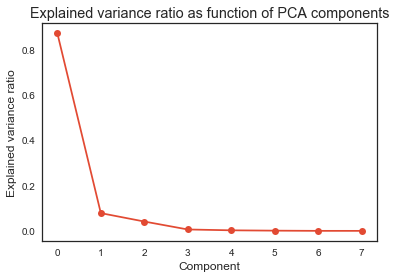

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(list(pca.explained_variance_ratio_),'-o')
plt.title('Explained variance ratio as function of PCA components')
plt.ylabel('Explained variance ratio')
plt.xlabel('Component')
plt.show()

###     分析结果可以发现，前两个变量的重要性比较大；因此我在之后使用了PCA降维成2之后的数据同样进行了分类。

## 5. Data sampling
### 根据数据统计，共有1639个正类和16259个负类，数据集过于不平衡，因此我做了一下数据采样，将比例调整为1:1
### 同时，由于我所使用的是KNN算法，需要计算属性向量之间的欧几里得距离，因此我使用了MinMaxScaler对数据进行了归一化处理，默认会将属性值归一化到区间[0, 1]之间。

In [8]:
# some data process
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import model_selection

# do Standardlization
X = MinMaxScaler().fit_transform(X)
Y = np.array(Y)

index_not = []
index_is = []
print(X.shape, Y.shape)
for index, x in enumerate(X):
    if Y[index] == 0:
        index_not.append(index)
    else:
        index_is.append(index)
print("total {} rows are detected as pulsar while {} rows aren't.".format(len(index_is), len(index_not)))

(17898, 8) (17898,)
total 1639 rows are detected as pulsar while 16259 rows aren't.


In [9]:
# 平衡数据集
import random
delete_not_index = random.sample(index_not, len(index_not) - len(index_is))
delete_not_index.sort(reverse=True)
for index in delete_not_index:
    X = np.delete(X, index, axis=0)
    Y = np.delete(Y, index, axis=0)

In [10]:
index_not = []
index_is = []
for index, x in enumerate(X):
    if Y[index] == 0:
        index_not.append(index)
    else:
        index_is.append(index)
print("total {} rows are detected as pulsar while {} rows aren't.".format(len(index_is), len(index_not)))
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.4, random_state=0)

total 1639 rows are detected as pulsar while 1639 rows aren't.


## 6. Classifier Selection
### 在选择分类器之前，我在网上找了一些关于


## 6. Classification
### Main task of this homework

In [11]:
from KNN import KNN  # import my KNN
cell_start=time()
k = KNN(n_neighbors=3)
k.fit(X_train, Y_train)
pred_knn = k.predict(X_test)
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Time Elapsed:  0.37860608100891113


In [12]:
def score(pred_y, test_y, print=False):
    tp, fp, tn, fn = [0,0,0,0]
    for index, y in enumerate(pred_y):
        if y == test_y[index]:
            if y == 0:
                tn += 1
            else:
                tp += 1
        else:
            if y == 0:
                fn += 1
            else:
                fp += 1
    if print:
        print("Accuracy: {}\nRecall: {}".format(tp/(tp+fp), tp/(tp+fn)))
    return tp/(tp+fp), tp/(tp+fn)
                

In [13]:
score(pred_knn, Y_test)

(0.910828025477707, 0.896551724137931)

## 7. Classification After PCA
### My extended task of this homework

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
newX = pca.fit_transform(X)
X_train_new, X_test_new, Y_train_new, Y_test_new = model_selection.train_test_split(newX, Y, test_size=0.4, random_state=0)
print(X_train_new.shape, Y_train_new.shape)

(1966, 2) (1966,)


In [15]:
from KNN import KNN  # import my KNN
cell_start=time()
k = KNN(n_neighbors=3)
k.fit(X_train_new, Y_train_new)
pred_knn_new = k.predict(X_test_new)
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Time Elapsed:  0.3435370922088623


In [16]:
score(pred_knn_new, Y_test_new)

(0.913322632423756, 0.8918495297805643)

## 5. Test how K matters

In [17]:
cell_start=time()
origin_rst = []
pca_rst = []
k_set = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 19, 24, 30, 37, 45, 54, 64, 75, 87, 100]
for k_neighbors in k_set:
    k = KNN()
    k = KNN(n_neighbors=k_neighbors)
    k.fit(X_train, Y_train)
    pred_knn = k.predict(X_test)
    origin_rst.append(score(pred_knn, Y_test))
    
    k.fit(X_train_new, Y_train_new)
    pred_knn_new = k.predict(X_test_new)
    pca_rst.append(score(pred_knn_new, Y_test_new))

cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Time Elapsed:  13.502904176712036


## 9. Result Analysis

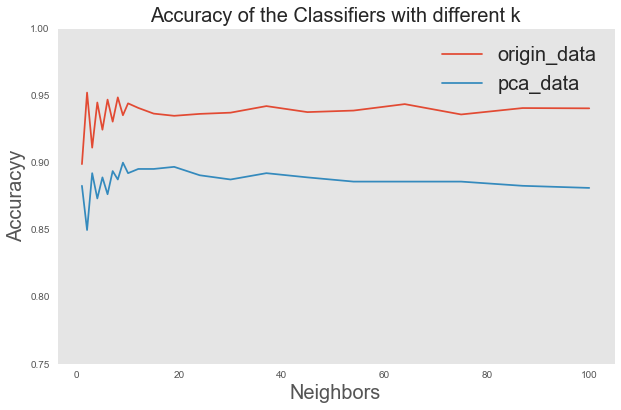

In [18]:
# drow a line
classifiers = ['svm', 'naive_bayes', 'logistic_regression', 'decision_tree', 'random_forest']
accuracy_data = [x[0] for x in origin_rst]
accuracy_data_pca = [x[1] for x in pca_rst]
plt.style.use('ggplot')
plt_index = k_set
plt.figure(figsize=(10, 10/1.618))
plt.ylim(0.75, 1)
plt.title("Accuracy of the Classifiers with different k", fontsize=20)
plt.xlabel("Neighbors", fontsize=20)
plt.ylabel("Accuracyy", fontsize=20)
plt.plot(plt_index, accuracy_data,'-',label="origin_data")
plt.plot(plt_index, accuracy_data_pca,'-',label="pca_data")
plt.legend(fontsize=20)
plt.grid()

###        从上图中我们可以发现， 当k从1上升到10时， 总体上有准确率上升的趋势。当k继续增加时，准确率并不会上升，反而在超过30时，有稍微下降的趋势。我认为，这个现象的出现原因在于数据集在高维空间上比较稀疏，导致当k增加时会包含到更多的错误类的点，从而导致分类出错。